In [1]:
import pandas as pd
import numpy as np

In [2]:
START, END = '2021-1-1', '2021-11-25'
data_tweet = pd.read_csv("covidvaccine_tweet_sentiment_veracity_BERT.csv", index_col=['date'], parse_dates=['date'])
data_vaccine = pd.read_csv("COVID-19_Vaccination_Trends_Population.csv", index_col=['Date'], parse_dates=['Date'], thousands=',')
data_tweet = data_tweet.loc[START:END]
data_vaccine = data_vaccine.loc[START:END]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  after removing the cwd from sys.path.


In [3]:
# Relabel
data_tweet['sentiment_score'] = data_tweet['sentiment_score'] - 1
data_tweet['veracity'] = data_tweet['veracity'].apply(lambda x : -1 if x == 0 else 1)

In [4]:
# Divided by states
vaccine_by_state = {}
tweet_by_state = {}
locs = data_tweet['user_location'].unique()
for i in range(len(locs)):
    loc = locs[i]
    tmp = data_tweet[data_tweet['user_location'] == loc]
    if len(tmp) > 500:
        tweet_by_state[loc] = tmp
        vaccine_by_state[loc] = data_vaccine[data_vaccine['Location']==loc]

In [5]:
# TODO Calculate Tweet Impact
def tweet_impact(state, f1, f2):
    table = tweet_by_state[state]
    sentiment = ((f1 * np.sqrt(table['user_followers'])) * table['sentiment_score']).resample('1D').mean()
    veracity = ((f2 * np.sqrt(table['user_followers'])) * table['veracity']).resample('1D').mean()
    # impact = table['sentiment_score']
    return sentiment, veracity

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' inst

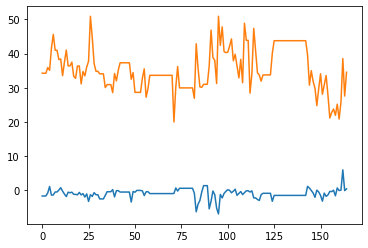

In [6]:
F1 = 0.4
F2 = 0.7
WINDOW = '2D'

from matplotlib import pyplot as plt
impact_score = []
vaccination_rate = []
for state in tweet_by_state:
    # Calculate Tweet Impact
    s1 = pd.Series(index=pd.date_range(start=START, end=END, freq='1D'))
    s2 = pd.Series(index=pd.date_range(start=START, end=END, freq='1D'))
    sentiment, veracity = tweet_impact(state, F1, F2)
    sentiment, veracity = sentiment.ewm(com=0.7).mean(), veracity.ewm(com=0.7).mean()
    s1[sentiment.index] = sentiment
    s2[veracity.index] = veracity
    s1.interpolate(method='polynomial', order=2, inplace=True)
    s2.interpolate(method='polynomial', order=2, inplace=True)
    s1 = s1.resample(WINDOW).mean()
    s2 = s2.resample(WINDOW).mean()
    impact_score.append([s1.tolist(),s2.tolist()])
    
    # Calculate vaccination rate
    vaccine = vaccine_by_state[state]
    # TODO Chooses "Administration" or "Report" date type
    vaccine = vaccine[vaccine['date_type'] == "Admin"]
    vaccine = vaccine.resample(WINDOW).mean()
    vaccine = vaccine.ewm(com=2).mean()
    vaccination_rate.append(vaccine['Administered_Daily'] / vaccine['Population'] * 100)

plt.plot(range(len(impact_score[4][0])), impact_score[4][0])
plt.plot(range(len(impact_score[4][0])), impact_score[4][1])
impact_score = np.array(impact_score)[:,:,:-2]
vaccination_rate = np.array(vaccination_rate)[:,:-2]

In [7]:
print(impact_score.shape)
print(vaccination_rate.shape)

(33, 2, 163)
(33, 163)


## LSTM

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures, normalize
from torchmetrics.functional import r2_score

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = np.transpose(impact_score, (0,2,1))
y_train = vaccination_rate.reshape(vaccination_rate.shape[0], vaccination_rate.shape[1], -1)


tmp_train = np.zeros((x_train.shape[0], x_train.shape[1], 10))
poly = PolynomialFeatures(3)
for i in range(x_train.shape[1]):
    tmp_train[:,i,:] = poly.fit_transform(x_train[:,i,:])
x_train = tmp_train

torch.FloatTensor()
x_valid = torch.from_numpy(x_train).float().to(device)
y_valid = torch.from_numpy(y_train).float().to(device)
x_train = torch.from_numpy(x_train[:,:int(x_train.shape[1]*0.8)]).float().to(device)
y_train = torch.from_numpy(y_train[:,:int(y_train.shape[1]*0.8)]).float().to(device)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

torch.Size([33, 130, 10])
torch.Size([33, 130, 1])
torch.Size([33, 163, 10])
torch.Size([33, 163, 1])


In [10]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()
        
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers = n_layers, dropout = dropout, batch_first = True)
        
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers = n_layers, dropout = dropout, batch_first = True)
        
        self.timedistribute = TimeDistributed(nn.Linear(hidden_dim, output_dim) , batch_first=True)
        
        
    def forward(self, data):

        #data = [batch size, sent len, input_dim]
        
        data = self.bn1(data.permute(0,2,1)).permute(0,2,1)
        
        encode_output, (hidden, cell) = self.encoder(data)
        
        encode_output = self.bn2(encode_output.permute(0,2,1)).permute(0,2,1)
        
        decode_output, _ = self.decoder(encode_output, (hidden, cell))
        
        return self.timedistribute(decode_output)

In [11]:
INPUT_DIM = 10
HIDDEN_DIM = 300
OUTPUT_DIM = 1
N_LAYERS = 3
DROPOUT = 0.5

model = RNN(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=0.0007)
criterion = torch.nn.HuberLoss()
model = model.to(device)
criterion = criterion.to(device)

In [12]:
def compute_r2(preds, y):
    r2 = 0
    n = len(preds)
    for i in range(n):
        r2 += r2_score(preds[i], y[i])
    return r2/n

In [13]:
def train(model, X, Y, optimizer, criterion):    
    model.train()
    
    optimizer.zero_grad()

    predictions = model(X)
    

    loss = criterion(predictions, Y)
    r2 = compute_r2(predictions.squeeze(2), Y.squeeze(2))

    loss.backward()

    optimizer.step()
        
    return loss.item(), r2.item()

In [14]:
def evaluate(model, X, Y, criterion):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        loss = criterion(predictions, Y)
        r2 = compute_r2(predictions[:,int(Y.shape[1]*0.8):,:].squeeze(2), Y[:,int(Y.shape[1]*0.8):,:].squeeze(2))
    return loss.item(), r2.item()

In [15]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    return predictions

In [16]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
N_EPOCHS = 150

best_valid_loss = float('inf')
train_loss = np.zeros(N_EPOCHS)
train_r2 = np.zeros(N_EPOCHS)
valid_loss = np.zeros(N_EPOCHS)
valid_r2 = np.zeros(N_EPOCHS)

for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_r2[i] = train(model, x_train, y_train, optimizer, criterion)
    valid_loss[i], valid_r2[i] = evaluate(model, x_valid, y_valid, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'lstm-model.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train R2: {train_r2[i]:.3f}')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. R2: {valid_r2[i]:.3f}')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.134 | Train R2: -2.613
	 Val. Loss: 0.090 |  Val. R2: -10.881
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.102 | Train R2: -1.687
	 Val. Loss: 0.068 |  Val. R2: -4.098
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.071 | Train R2: -0.821
	 Val. Loss: 0.047 |  Val. R2: -0.397
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.045 | Train R2: -0.170
	 Val. Loss: 0.034 |  Val. R2: -4.805
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.059 | Train R2: -0.761
	 Val. Loss: 0.034 |  Val. R2: -4.305
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.044 | Train R2: -0.177
	 Val. Loss: 0.036 |  Val. R2: -2.433
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.042 | Train R2: -0.034
	 Val. Loss: 0.037 |  Val. R2: -1.615
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.040 | Train R2: 0.002
	 Val. Loss: 0.037 |  Val. R2: -1.493
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.040 | Train R2: -0.002
	 Val. Loss: 0.036 |  Val. R2: -1.803
Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.0

In [18]:
model.load_state_dict(torch.load('lstm-model.pt'))
y_pred = predict(model, x_valid)

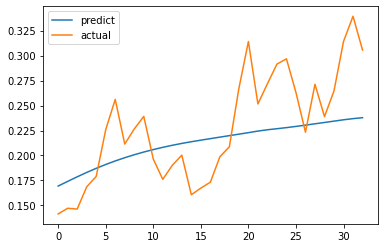

In [24]:
y1 = y_pred[14].squeeze(1).detach().cpu().numpy()
y2 = y_valid[14].squeeze(1).detach().cpu().numpy()
y1, y2 = y1[int(len(y1)*0.8):], y2[int(len(y1)*0.8):],
plt.plot(range(len(y1)), y1, label='predict')
plt.plot(range(len(y2)), y2, label='actual')
plt.legend()
plt.show()